# Import Bibliotecas

In [ ]:
!pip install unidecode libpysal esda

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
import numpy as np
from matplotlib import colors

# Bibliotecas para estatística espacial
import libpysal
import esda
import geopandas as gpd

from libpysal.weights import Queen
from esda.moran import Moran
import matplotlib.pyplot as plt
from esda.moran import Moran_Local

# Cores para o mapa bivariado
from matplotlib.colors import ListedColormap
# Adicionar legenda personalizada
import matplotlib.patches as mpatches

# import dados

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_censo=pd.read_csv('/content/dados_censo.csv', sep=',')
df_pib=pd.read_csv('/content/PIB dos Municípios GO.csv', sep=',', encoding='latin-1')
#df_eleição=pd.read_csv('/content/drive/My Drive/votacao_2022_GO.csv',sep=';',encoding='latin-1')
df_eleição = pd.read_csv('/content/drive/My Drive/votacao_2022_GO.csv',sep=';',encoding='latin-1', usecols=['DS_CARGO', 'SQ_CANDIDATO', 'CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS'])


gdf = gpd.read_file('/content/GO_Municipios_2022.zip')
df_seguranca = pd.read_csv('/content/segurança.csv', encoding='utf-8', sep=';')

In [ ]:
df_eleição['NM_MUNICIPIO'] = df_eleição['NM_MUNICIPIO'].apply(unidecode).str.upper()

In [ ]:
df_deputados = df_eleição[
    (df_eleição['DS_CARGO'] == 'DEPUTADO FEDERAL') &
    (~df_eleição['NM_VOTAVEL'].isin(['VOTO BRANCO', 'VOTO NULO']))
]
df_deputados = df_deputados[['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS']]

In [ ]:
df_censo['municipio'] = df_censo['municipio'].str.upper()
df_censo['municipio'] = df_censo['municipio'].replace({
    "ANHANGÜERA": "ANHANGUERA",
    "SÃO JOÃO D'ALIANÇA": "SÃO JOÃO D ALIANÇA",
    "SÃO LUÍS DE MONTES BELOS": "SÃO LUÍS DE MONTES BELOS",
    "SÍTIO D'ABADIA": "SÍTIO D ABADIA"
})
df_censo['municipio'] = df_censo['municipio'].fillna('').apply(str).apply(unidecode).str.upper()

df_censo['municipio']

0         ABADIA DE GOIAS
1               ABADIANIA
2                 ACREUNA
3               ADELANDIA
4      AGUA FRIA DE GOIAS
              ...        
241                VARJAO
242            VIANOPOLIS
243        VICENTINOPOLIS
244              VILA BOA
245         VILA PROPICIO
Name: municipio, Length: 246, dtype: object

In [ ]:
# Garantir que as colunas de chave tenham o mesmo nome e tipo para a junção
gdf = gdf.rename(columns={"CD_MUN": "CD_MUNICIPIO"})
gdf = gdf.rename(columns={"NM_MUN": "NM_MUNICIPIO"})

gdf['NM_MUNICIPIO'] = gdf['NM_MUNICIPIO'].apply(unidecode).str.upper()
gdf['NM_MUNICIPIO'] = gdf['NM_MUNICIPIO'].replace({
    "SITIO D'ABADIA": "SITIO D ABADIA",
    "SAO JOAO D'ALIANCA": "SAO JOAO D ALIANCA"
})

In [ ]:
# Filtrando apenas candidados a deputado federal
df_candidatos = df_eleição[
    (df_eleição['DS_CARGO'] == 'DEPUTADO FEDERAL') &
    (~df_eleição['SQ_CANDIDATO'].isin([-3]))
]
df_candidatos = df_candidatos[['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS']]

In [ ]:
df_candidatos['CD_MUNICIPIO'] = df_candidatos['CD_MUNICIPIO'].astype('int32')
df_candidatos['QT_VOTOS'] = df_candidatos['QT_VOTOS'].astype('int32')

In [ ]:
# Agrupar por NM_VOTAVEL e CD_MUNICIPIO, somando os votos (QT_VOTOS)
df_votos_candidatos = df_candidatos.groupby(['NM_VOTAVEL', 'CD_MUNICIPIO','NM_MUNICIPIO'])['QT_VOTOS'].sum().reset_index()

In [ ]:
# Unir os dados espaciais e os votos por candidato
gdf_candidatos = gdf.merge(df_votos_candidatos, on="NM_MUNICIPIO", how="inner")

In [ ]:
gdf_candidatos

CD_MUNICIPIO_x     NM_MUNICIPIO SIGLA_UF  AREA_KM2  \
0            5200050  ABADIA DE GOIAS       GO   143.357   
1            5200050  ABADIA DE GOIAS       GO   143.357   
2            5200050  ABADIA DE GOIAS       GO   143.357   
3            5200050  ABADIA DE GOIAS       GO   143.357   
4            5200050  ABADIA DE GOIAS       GO   143.357   
...              ...              ...      ...       ...   
34122        5222302    VILA PROPICIO       GO  2181.593   
34123        5222302    VILA PROPICIO       GO  2181.593   
34124        5222302    VILA PROPICIO       GO  2181.593   
34125        5222302    VILA PROPICIO       GO  2181.593   
34126        5222302    VILA PROPICIO       GO  2181.593   

                                                geometry  \
0      POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...   
1      POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...   
2      POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...   
3      POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...   
4      POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...   
...                                                  ...   
34122  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...   
34123  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...   
34124  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...   
34125  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...   
34126  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...   

                               NM_VOTAVEL  CD_MUNICIPIO_y  QT_VOTOS  
0                    AAVA SANTIAGO AGUIAR           93360        20  
1                  ACENIL GUERRA DA COSTA           93360        48  
2                   ADELSON JOSÉ DE SOUZA           93360         1  
3                ADRIANA SAUTHIER ACCORSI           93360       225  
4                  ADRIANO ANTONIO AVELAR           93360      1411  
...                                   ...             ...       ...  
34122         WAGNER SIQUEIRA DE OLIVEIRA           93505         1  
34123             WALKIRIA CRISTINA ALVES           93505         3  
34124  WESTHARLLEY DANIEL DE SOUZA RAPOSO           93505         4  
34125                 ZACARIAS CALIL HAMU           93505         7  
34126                ZAIRA PERES SIQUEIRA           93505         1  

[34127 rows x 8 columns]

In [ ]:
# Normalização dos votos por candidato: proporção de votos em cada municipio
gdf_candidatos['PROP_VOTOS'] = gdf_candidatos['QT_VOTOS'] / gdf_candidatos.groupby('NM_VOTAVEL')['QT_VOTOS'].transform('sum')

# Agrupando por partido

## Agrupando Partidos

In [ ]:
partidos = {
    '13': 'PT',
    '22': 'PL',
    '44': 'UB',
    '12': 'PDT',
    '20': 'PODE',
    '11': 'PP',
    '15': 'MDB',
    '45': 'PSDB',
    '10': 'REPUBLICANOS',
    '55': 'PSD'
}

df_deputados['PREFIXO'] = df_deputados['NR_VOTAVEL'].astype(str).str[:2]

# Adicionar a coluna com o nome do partido com base no prefixo
df_deputados['PARTIDO'] = df_deputados['PREFIXO'].map(partidos)

# Filtrar os valores válidos (descartar onde o partido não está na lista)
df_partido = df_deputados.dropna(subset=['PARTIDO'])

# Agrupar por PARTIDO e CD_MUNICIPIO, somando os votos (QT_VOTOS)
df_partido = df_partido.groupby(['PARTIDO', 'CD_MUNICIPIO','NM_MUNICIPIO'])['QT_VOTOS'].sum().reset_index()

In [ ]:
df_partido

PARTIDO  CD_MUNICIPIO        NM_MUNICIPIO  QT_VOTOS
0        MDB         92010           ABADIANIA       743
1        MDB         92029        BONFINOPOLIS      1064
2        MDB         92037          AGUA LIMPA        51
3        MDB         92053            ALEXANIA      2778
4        MDB         92061       CAMPOS VERDES       295
...      ...           ...                 ...       ...
2455      UB         96814             INDIARA       326
2456      UB         96873           CAMPINACU        29
2457      UB         96890        SANTA ISABEL       108
2458      UB         96911           ADELANDIA        92
2459      UB         96938  AGUA FRIA DE GOIAS        24

[2460 rows x 4 columns]

## Autocorrelação por partido

In [ ]:
gdf

CD_MUNICIPIO        NM_MUNICIPIO SIGLA_UF  AREA_KM2  \
0        5200050     ABADIA DE GOIAS       GO   143.357   
1        5200100           ABADIANIA       GO  1044.555   
2        5200134             ACREUNA       GO  1566.742   
3        5200159           ADELANDIA       GO   115.385   
4        5200175  AGUA FRIA DE GOIAS       GO  2023.636   
..           ...                 ...      ...       ...   
241      5221908              VARJAO       GO   517.402   
242      5222005          VIANOPOLIS       GO   954.115   
243      5222054      VICENTINOPOLIS       GO   733.794   
244      5222203            VILA BOA       GO  1052.593   
245      5222302       VILA PROPICIO       GO  2181.593   

                                              geometry  
0    POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...  
1    POLYGON ((-48.67246 -16.28556, -48.67248 -16.2...  
2    POLYGON ((-50.07007 -17.48691, -50.06993 -17.4...  
3    POLYGON ((-50.17913 -16.43049, -50.17928 -16.4...  
4    POLYGON ((-47.85694 -14.76464, -47.85674 -14.7...  
..                                                 ...  
241  POLYGON ((-49.70133 -17.0852, -49.70136 -17.08...  
242  POLYGON ((-48.31126 -16.84221, -48.3117 -16.84...  
243  POLYGON ((-49.73613 -17.74427, -49.73624 -17.7...  
244  POLYGON ((-47.0778 -15.06364, -47.07799 -15.06...  
245  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...  

[246 rows x 5 columns]

In [ ]:
# Unir os dados espaciais e os votos por partido
gdf_merged = gdf.merge(df_partido, on="NM_MUNICIPIO", how="inner")

# Verificar as primeiras linhas do GeoDataFrame combinado
gdf_merged


CD_MUNICIPIO_x     NM_MUNICIPIO SIGLA_UF  AREA_KM2  \
0           5200050  ABADIA DE GOIAS       GO   143.357   
1           5200050  ABADIA DE GOIAS       GO   143.357   
2           5200050  ABADIA DE GOIAS       GO   143.357   
3           5200050  ABADIA DE GOIAS       GO   143.357   
4           5200050  ABADIA DE GOIAS       GO   143.357   
...             ...              ...      ...       ...   
2455        5222302    VILA PROPICIO       GO  2181.593   
2456        5222302    VILA PROPICIO       GO  2181.593   
2457        5222302    VILA PROPICIO       GO  2181.593   
2458        5222302    VILA PROPICIO       GO  2181.593   
2459        5222302    VILA PROPICIO       GO  2181.593   

                                               geometry       PARTIDO  \
0     POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...           MDB   
1     POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...           PDT   
2     POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...            PL   
3     POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...          PODE   
4     POLYGON ((-49.43754 -16.86015, -49.43849 -16.8...            PP   
...                                                 ...           ...   
2455  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...           PSD   
2456  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...          PSDB   
2457  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...            PT   
2458  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...  REPUBLICANOS   
2459  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...            UB   

      CD_MUNICIPIO_y  QT_VOTOS  
0              93360        99  
1              93360       195  
2              93360      1379  
3              93360       424  
4              93360      1538  
...              ...       ...  
2455           93505        15  
2456           93505       460  
2457           93505       223  
2458           93505        86  
2459           93505        81  

[2460 rows x 8 columns]

In [ ]:
# Mapa da quantidade de votos
fig, ax = plt.subplots(figsize=(12, 8))

# Criar uma coluna logarítmica
gdf_merged = gdf_merged.copy()
gdf_merged['QT_VOTOS_log'] = np.log(gdf_merged['QT_VOTOS'])

# Definir o colormap
vmin_log = np.log(gdf_merged['QT_VOTOS'].min())
vmax_log = np.log(gdf_merged['QT_VOTOS'].max())
norm = colors.Normalize(vmin=vmin_log, vmax=vmax_log)

# Plotar o mapa com escala logarítmica
gdf_merged.plot(column='QT_VOTOS_log', cmap='OrRd', legend=True, ax=ax)
ax.set_title("Distribuição de Votos por Município", fontsize=14)
plt.show()

In [ ]:
w_global = Queen.from_dataframe(gdf_merged)
w_global.transform = 'r'

# Obter lista de partidos únicos
partidos = gdf_merged['PARTIDO'].unique()

# Armazenar resultados
resultados = []

for partido in partidos:
    # Filtrar o GeoDataFrame por partido
    subset = gdf_merged[gdf_merged['PARTIDO'] == partido]

    # Criar matriz de pesos espaciais para o subconjunto
    w = Queen.from_dataframe(subset)
    w.transform = 'r'

    # Obter a variável de interesse
    qt_votos = subset['QT_VOTOS']

    # Calcular o índice de Moran
    moran = Moran(qt_votos, w)

    # Armazenar resultados
    resultados.append({
        'PARTIDO': partido,
        'Índice de Moran': moran.I,
        'p-valor': moran.p_sim,
        'z-score': moran.z_sim
    })

    # Visualizar gráfico de dispersão para cada partido
    print(f"Resultados para o partido {partido}")

# Consolidar os resultados em um DataFrame
df_resultados = pd.DataFrame(resultados)

# Exibir os resultados
print(df_resultados)

<ipython-input-22-fd39dfc01853>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_global = Queen.from_dataframe(gdf_merged)
<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido MDB


<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido PDT


<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido PL


<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido PODE


<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido PP


<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido PSD


<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido PSDB


<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido PT


<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido REPUBLICANOS


<ipython-input-22-fd39dfc01853>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)


Resultados para o partido UB
        PARTIDO  Índice de Moran  p-valor   z-score
0           MDB         0.099572    0.026  2.743668
1           PDT         0.095383    0.018  3.017364
2            PL         0.103674    0.011  5.037519
3          PODE         0.100341    0.019  3.495028
4            PP        -0.028585    0.242 -0.710329
5           PSD         0.030481    0.069  1.292899
6          PSDB         0.139561    0.011  4.509317
7            PT         0.057258    0.029  2.971602
8  REPUBLICANOS         0.117239    0.017  4.006461
9            UB         0.142680    0.004  7.148015


In [ ]:
# Barplot do Índice de Moran por Partido
plt.figure(figsize=(10, 6))
sns.barplot(x="PARTIDO", y="Índice de Moran", data=df_resultados, palette="coolwarm")
plt.title("Índice de Moran por Partido", fontsize=14)
plt.ylabel("Índice de Moran")
plt.xlabel("Partido")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")  # Linha de referência
plt.show()

<ipython-input-23-b34ee8e691f6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PARTIDO", y="Índice de Moran", data=df_resultados, palette="coolwarm")


<ipython-input-24-dead47875c54>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PARTIDO", y="p-valor", data=df_resultados, palette="magma")


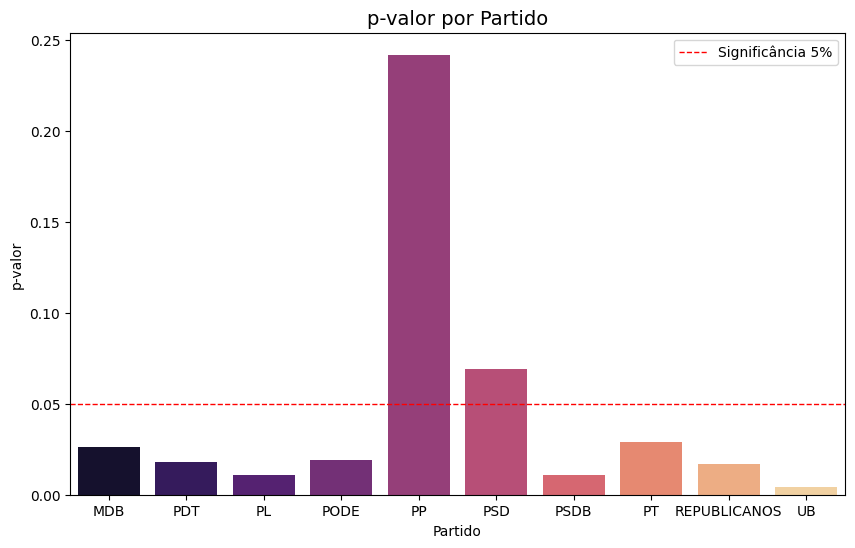

In [ ]:
# Gráfico de barras para p-valores
plt.figure(figsize=(10, 6))
sns.barplot(x="PARTIDO", y="p-valor", data=df_resultados, palette="magma")
plt.title("p-valor por Partido", fontsize=14)
plt.ylabel("p-valor")
plt.xlabel("Partido")
plt.axhline(0.05, color="red", linewidth=1, linestyle="--", label="Significância 5%")  # Linha de significância
plt.legend()
plt.show()

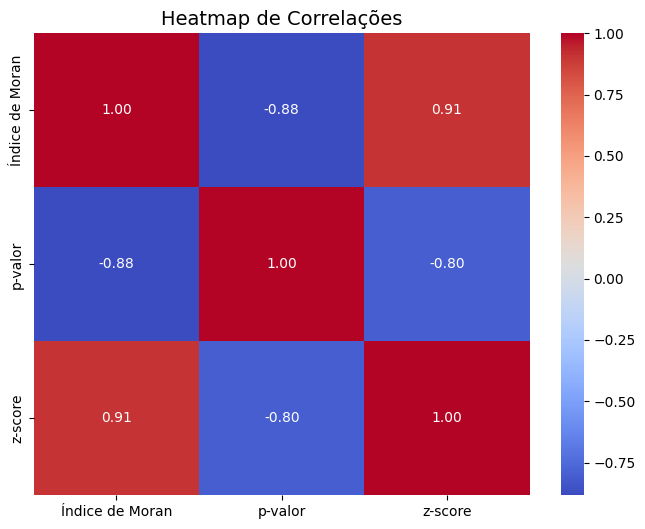

In [ ]:
# Heatmap de correlações
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_resultados[["Índice de Moran", "p-valor", "z-score"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Heatmap de Correlações", fontsize=14)
plt.show()

<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


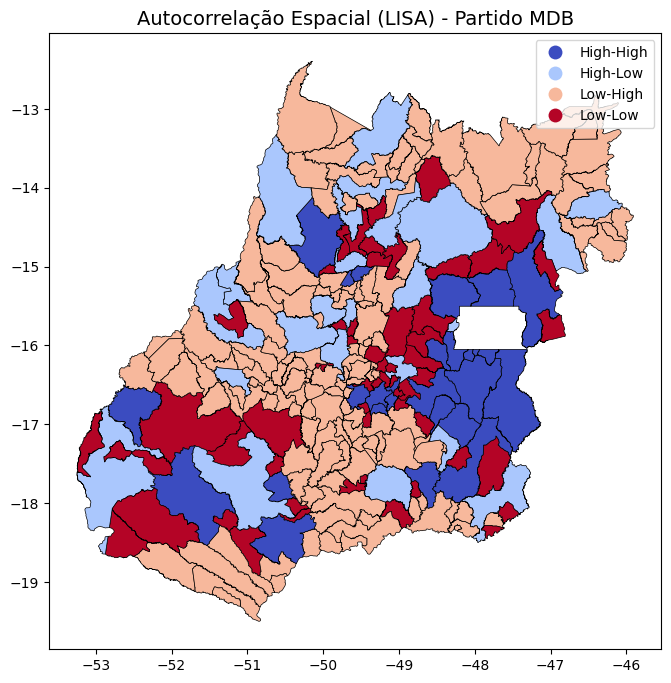

<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


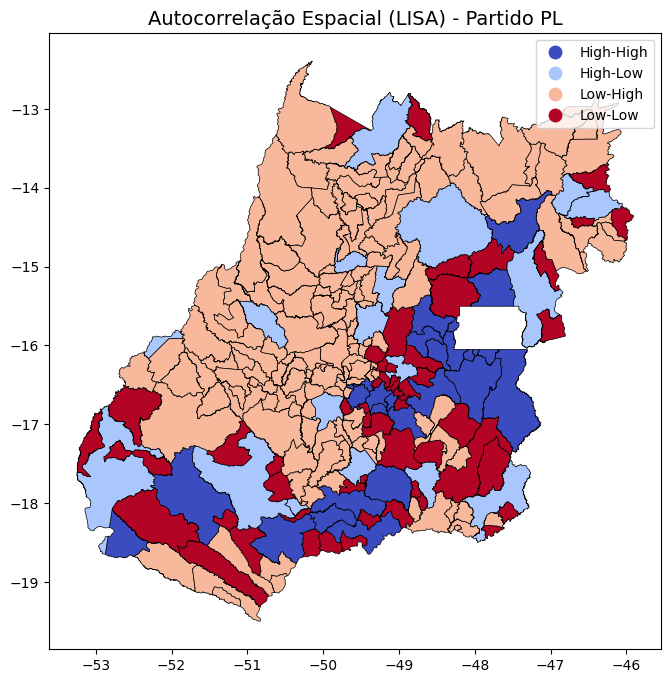

<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


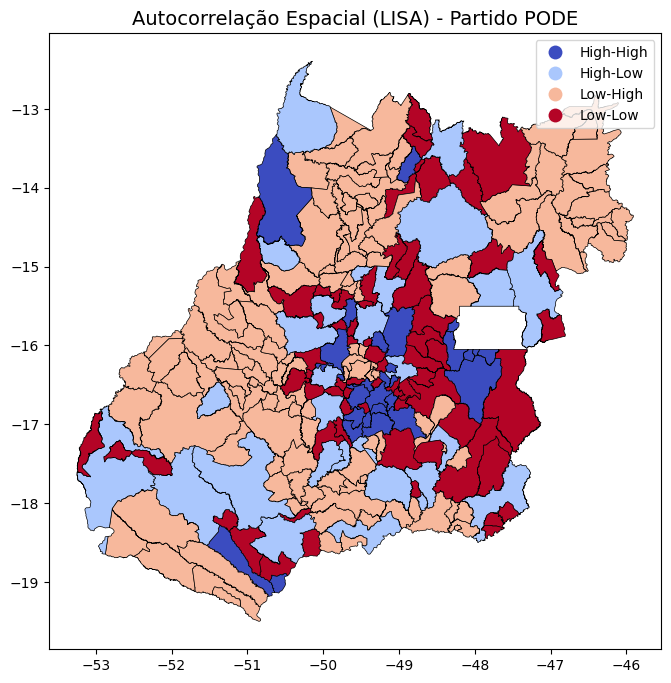

<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


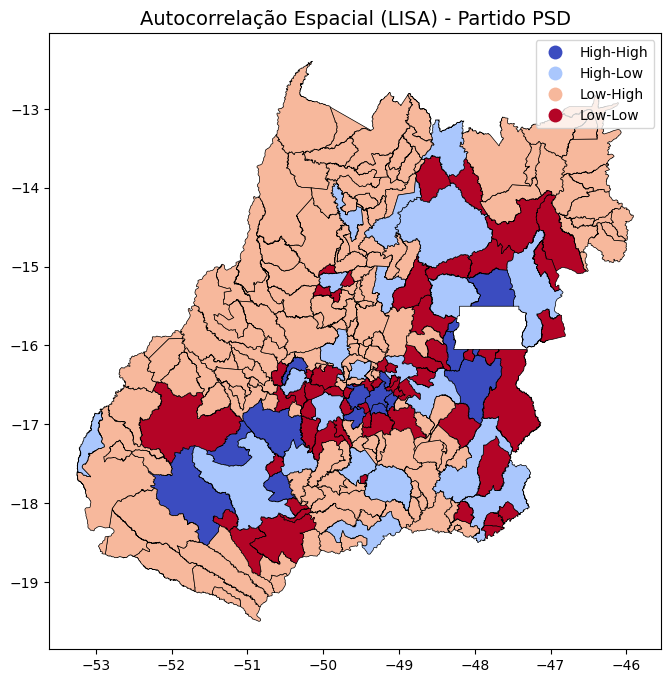

<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


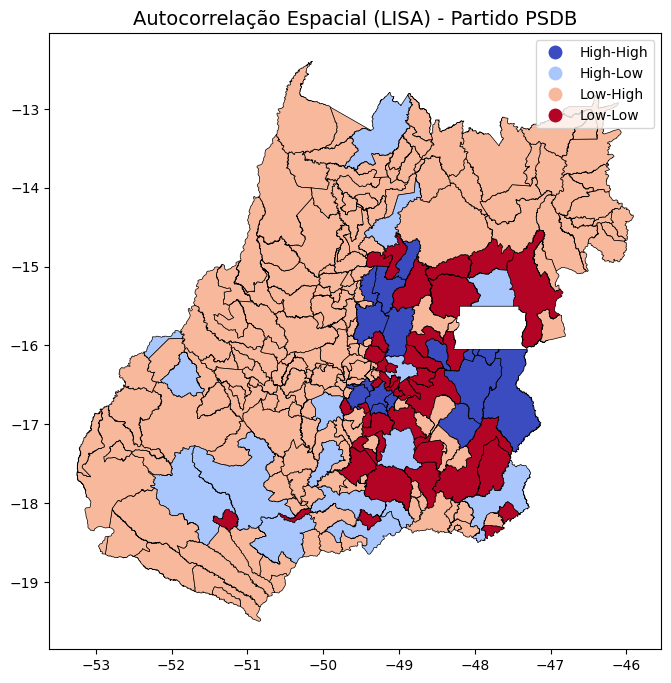

<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


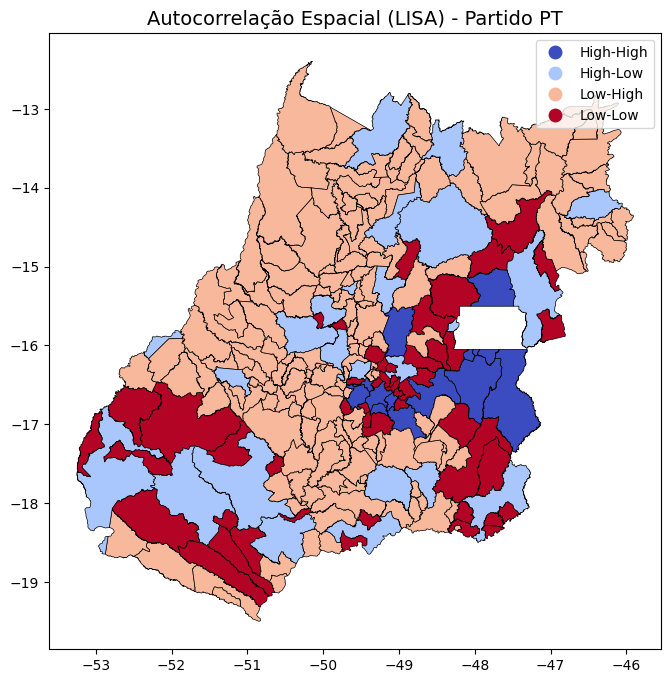

<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


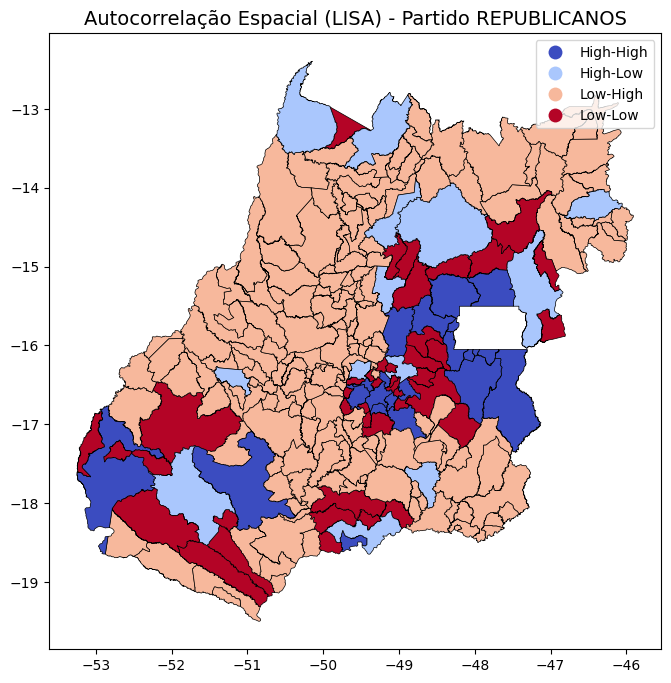

<ipython-input-30-316745909fa4>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


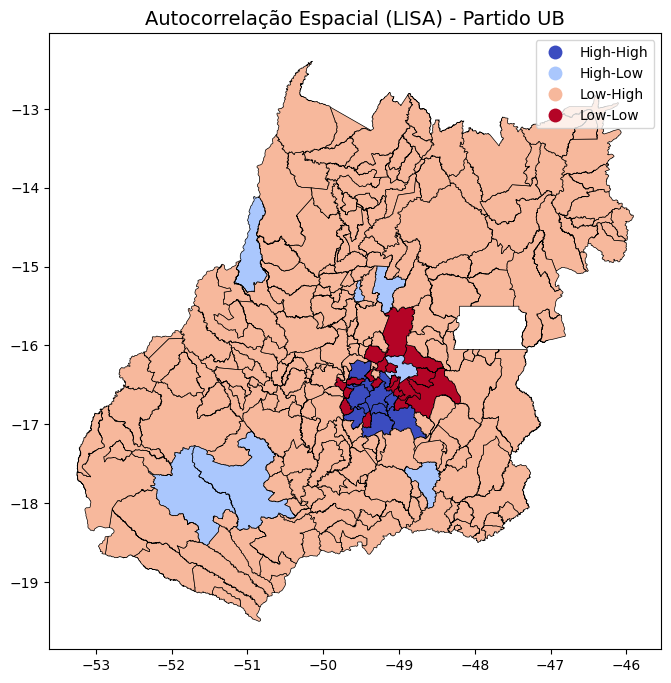

In [ ]:
for partido in partidos:
    subset = gdf_merged[gdf_merged['PARTIDO'] == partido]

    # Criar matriz de pesos espaciais
    w = Queen.from_dataframe(subset)
    w.transform = 'r'

    # Variável de interesse
    qt_votos = subset['QT_VOTOS']

    # Calcular Moran Local
    moran_local = Moran_Local(qt_votos, w)

    # Adicionar clusters ao GeoDataFrame
    subset['LISA_Cluster'] = moran_local.q  # 1: HH, 2: LL, 3: LH, 4: HL

    # Plotar clusters no mapa
    fig, ax = plt.subplots(1, figsize=(10, 8))
    subset.assign(
        LISA_Label=subset['LISA_Cluster'].map({
            1: 'High-High',
            2: 'Low-Low',
            3: 'Low-High',
            4: 'High-Low'
        })
    ).plot(
        column='LISA_Label',
        cmap='coolwarm',
        legend=True,
        ax=ax,
        edgecolor='black',
        linewidth=0.5
    )
    ax.set_title(f"Autocorrelação Espacial (LISA) - Partido {partido}", fontsize=14)
    plt.show()

# Analise Extra

## Existe correlação entre os votos nas cidades com maiores taxas de alfabetização e candidatos professores?

In [ ]:
data = {
    "NOME": [
        "PROFESSOR ALCIDES",
        "PROFESSOR EDWARD",
        "PROFESSOR FLAVIANO",
        "PROFESSOR MÁRCIO",
        "PROFESSOR MOACIR",
        "PROFESSOR RAILTON",
        "PROFESSORA LUCIA BATISTA",
        "PROFESSORA LÚCIA VASCONCELOS",
        "PROFESSORA MEIRE",
        "PROFESSORA NAILDE",
        "PROFESSORA PATRÍCIA SOARES",
        "PROF ELIETE PAIXÃO",
        "PROF ISABEL MORENO",
        "PROF. EDER BENTO"

    ],
    "NUMERO": [
        2250,
        1310,
        4011,
        4007,
        1202,
        6565,
        4010,
        4477,
        3613,
        4550,
        1999,
        7778,
        2000,
        3077
    ]}
df_professores = pd.DataFrame(data)
df_professores = df_professores.merge(df_deputados, left_on='NUMERO', right_on='NR_VOTAVEL', how='inner')
df_professores = (
    df_professores
    .groupby(['CD_MUNICIPIO', 'NM_MUNICIPIO'], as_index=False)
    .agg({'QT_VOTOS': 'sum'})
)

df_professores = df_professores.merge(df_censo, left_on='NM_MUNICIPIO', right_on='municipio', how='inner')
df_professores['tx_Vot'] = df_professores['QT_VOTOS'] / df_professores['habitantes']

In [ ]:
correlacao = df_professores['tx_Vot'].corr(df_professores['taxa_alfabetizacao'])
correlacao

-0.08880730827121477

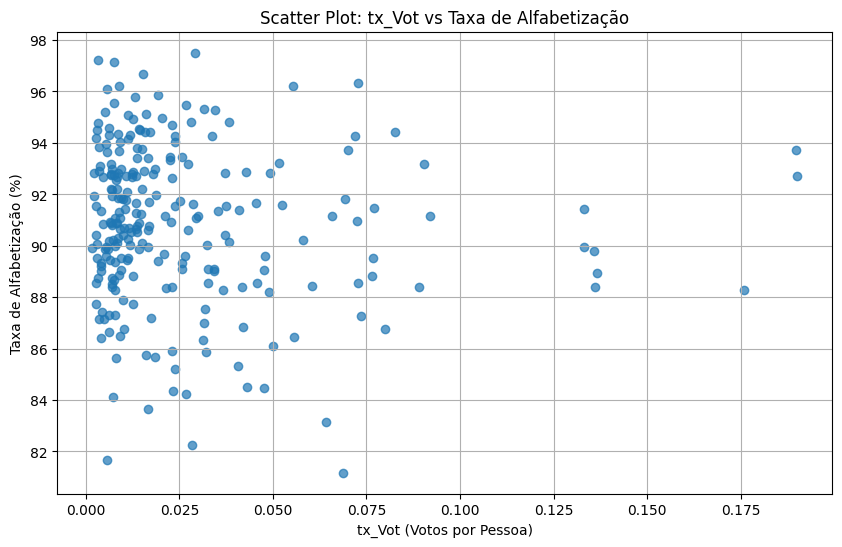

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_professores['tx_Vot'], df_professores['taxa_alfabetizacao'], alpha=0.7)
plt.title("Scatter Plot: tx_Vot vs Taxa de Alfabetização")
plt.xlabel("tx_Vot (Votos por Pessoa)")
plt.ylabel("Taxa de Alfabetização (%)")
plt.grid(True)
plt.show()

In [ ]:
# Criar um GeoDataFrame para mapas
gdf_professores = gpd.GeoDataFrame(df_professores.merge(gdf, on='NM_MUNICIPIO', how='inner'))

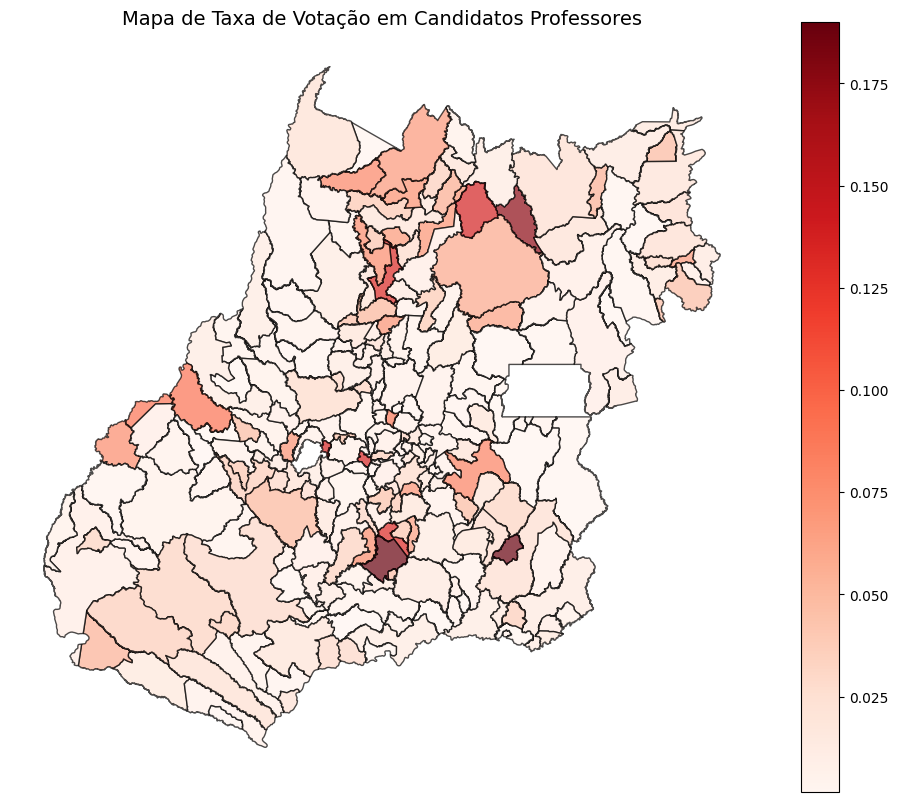

In [ ]:
# Visualizar no mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_professores.plot(
    ax=ax,
    column='tx_Vot',
    cmap='Reds',
    legend=True,
    edgecolor="black",
    alpha=0.7
)
plt.title("Mapa de Taxa de Votação em Candidatos Professores", fontsize=14)
ax.axis("off")
plt.show()

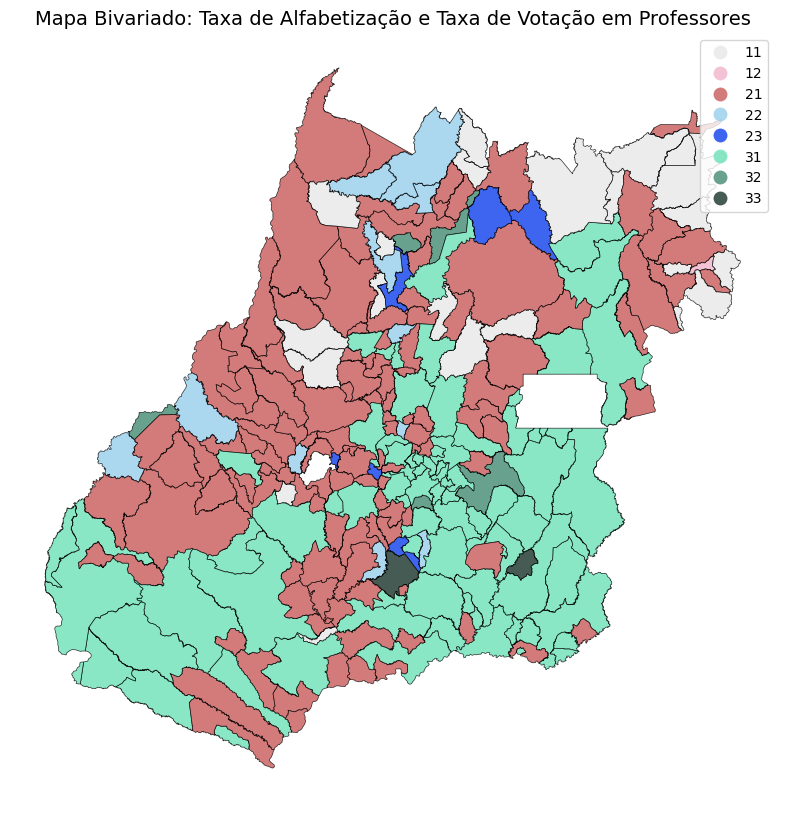

In [ ]:
# Normalizar as variáveis
df_professores['alfabetizacao_norm'] = df_professores['taxa_alfabetizacao'] / df_professores['taxa_alfabetizacao'].max()
df_professores['tx_Vot_norm'] = df_professores['tx_Vot'] / df_professores['tx_Vot'].max()

# Criar classes para as variáveis
df_professores['alfabetizacao_class'] = pd.cut(
    df_professores['alfabetizacao_norm'], bins=3, labels=[1, 2, 3]
)
df_professores['votacao_class'] = pd.cut(
    df_professores['tx_Vot_norm'], bins=3, labels=[1, 2, 3]
)

# Combinar as classes para criar o índice bivariado
df_professores['bivar_class'] = (
    df_professores['alfabetizacao_class'].astype(int).astype(str) +
    df_professores['votacao_class'].astype(int).astype(str)
)

# Criar uma paleta de cores bivariada
bivariate_cmap = ListedColormap([
    "#e8e8e8",  # Baixo-Baixo
    "#F2B3CB",  # Baixo-Médio
    "#c85a5a",  # Baixo-Alto
    "#96CDEB",  # Médio-Baixo
    "#4794EB",  # Médio-Médio
    "#0E3EEB",  # Médio-Alto
    "#6CE1B8",  # Alto-Baixo
    "#428A71",  # Alto-Médio
    "#183229",  # Alto-Alto
])

# Adicionar as geometrias ao DataFrame
gdf_professores = gpd.GeoDataFrame(df_professores.merge(gdf, on='NM_MUNICIPIO'))

# Criar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_professores.plot(
    ax=ax,
    column='bivar_class',
    cmap=bivariate_cmap,
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.8
)
plt.title("Mapa Bivariado: Taxa de Alfabetização e Taxa de Votação em Professores", fontsize=14)
ax.axis("off")
plt.show()

Legendas:

    '11': 'Baixa Alfabetização e Baixa Votação',
    '12': 'Baixa Alfabetização e Média Votação',
    '13': 'Baixa Alfabetização e Alta Votação',
    '21': 'Média Alfabetização e Baixa Votação',
    '22': 'Média Alfabetização e Média Votação',
    '23': 'Média Alfabetização e Alta Votação',
    '31': 'Alta Alfabetização e Baixa Votação',
    '32': 'Alta Alfabetização e Média Votação',
    '33': 'Alta Alfabetização e Alta Votação'

## Existe correlação entre os votos nas cidades com maiores taxas de homicidios e candidatos que levam no nome classes policiais?

In [ ]:
dados = {
    "NOME": [
        "SUBTENENTE AURÉLIO", "SUBTENENTE DA MATA", "SUBTENENTE GILSON GOMES", "SUBTENENTE SOUZA",
        "SARGENTO CIDA", "SARGENTO DENISE BRASIL", "MAJOR HUGO CHRISTIANI", "DELEGADA ADRIANA ACCORSI",
        "DELEGADO EDUARDO RODOVALHO", "DELEGADO EDUARDO RODOVALHO", "DELEGADO FEDERAL HUMBERTO",
        "DELEGADO HUMBERTO TEÓFILO", "DELEGADO RAFAEL", "CORONEL ANÉSIO", "CORONEL BENITO FRANCO",
        "CORONEL DIGUES", "CORONEL EDSON RAIADO", "CORONEL HELBINGEN", "CORONEL LAERCIO", "CORONEL WELLINGTON"
    ],
    "NUMERO": [
        1400, 3340, 1345, 4400, 1440, 1540, 2201, 1331, 9090, 9090, 5101, 5122, 7717,
        5190, 2227, 1478, 7090, 1401, 1940, 1901
    ]
}

df_policia = pd.DataFrame(dados)
df_policia = df_policia.merge(df_deputados, left_on='NUMERO', right_on='NR_VOTAVEL', how='inner')
df_policia = (
    df_policia
    .groupby(['CD_MUNICIPIO', 'NM_MUNICIPIO'], as_index=False)
    .agg({'QT_VOTOS': 'sum'})
)
df_policia['NM_MUNICIPIO'] = df_policia['NM_MUNICIPIO'].replace({
    "SÃO JOÃO D'ALIANÇA": "SÃO JOÃO D ALIANÇA",
    "SÍTIO D'ABADIA": "SÍTIO D ABADIA"
})

df_policia = df_policia.merge(df_censo, left_on='NM_MUNICIPIO', right_on='municipio', how='inner')
df_policia['tx_Vot'] = df_policia['QT_VOTOS'] / df_professores['habitantes']

In [ ]:
correlacao = df_policia['tx_Vot'].corr(df_policia['taxa_alfabetizacao'])
correlacao

0.147660217921222

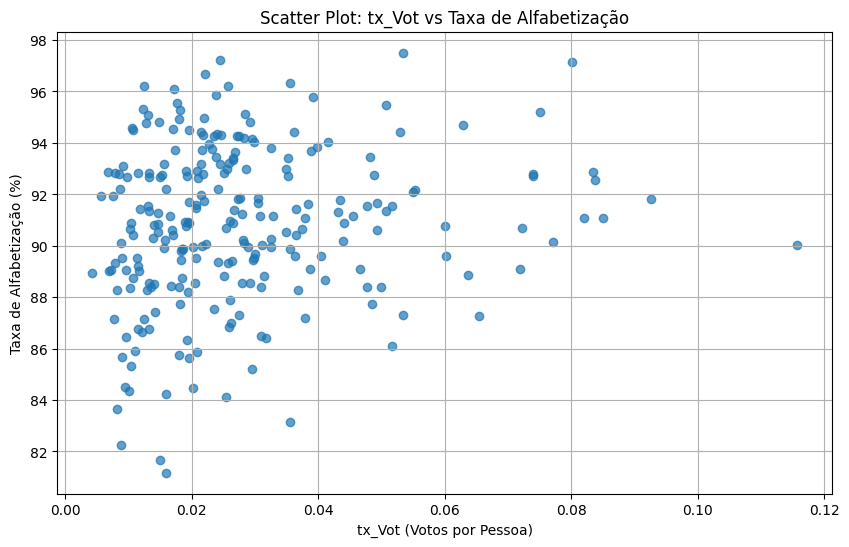

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_policia['tx_Vot'], df_policia['taxa_alfabetizacao'], alpha=0.7)
plt.title("Scatter Plot: tx_Vot vs Taxa de Alfabetização")
plt.xlabel("tx_Vot (Votos por Pessoa)")
plt.ylabel("Taxa de Alfabetização (%)")
plt.grid(True)
plt.show()

In [ ]:
df_seguranca['Cidade'] = df_seguranca['Cidade'].str.upper()
df_seguranca['Cidade'] = df_seguranca['Cidade'].replace({
    "ANHANGÜERA": "ANHANGUERA",
    "SÃO JOÃO D'ALIANÇA": "SÃO JOÃO D ALIANÇA",
    "SÃO LUÍS DE MONTES BELOS": "SÃO LUÍS DE MONTES BELOS",
    "SÍTIO D'ABADIA": "SÍTIO D ABADIA"
})
df_seguranca['Cidade'] = df_seguranca['Cidade'].fillna('').apply(str).apply(unidecode).str.upper()

df_seguranca['Cidade']

0         ABADIA DE GOIAS
1               ABADIANIA
2                 ACREUNA
3               ADELANDIA
4      AGUA FRIA DE GOIAS
              ...        
241                VARJAO
242            VIANOPOLIS
243        VICENTINOPOLIS
244              VILA BOA
245         VILA PROPICIO
Name: Cidade, Length: 246, dtype: object

In [ ]:
# Substituindo NaN por -1 em todo o DataFrame
df_seguranca.fillna(-1, inplace=True)

In [ ]:
df_policia = pd.merge(df_policia, df_seguranca, left_on='NM_MUNICIPIO', right_on='Cidade', how='inner')

In [ ]:
correlacao = df_policia['tx_Vot'].corr(df_policia['Homicidios Dolosos'])
correlacao

0.057023730862545974

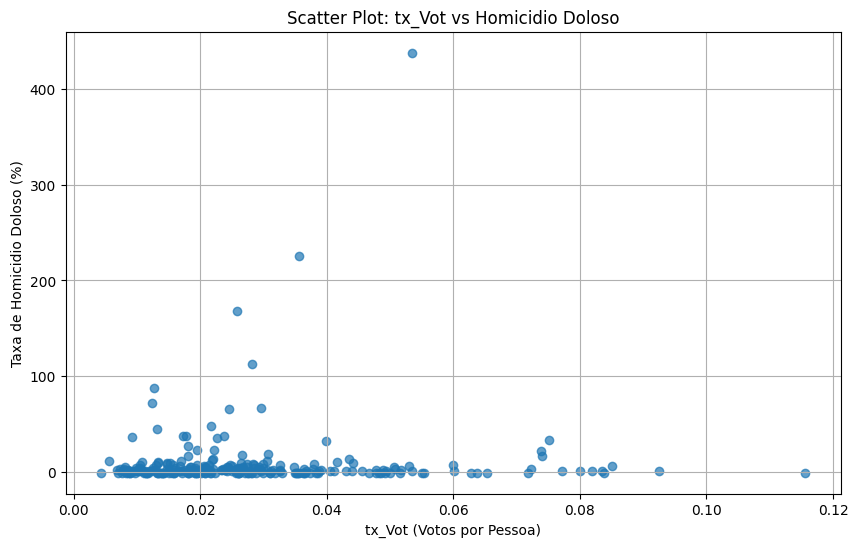

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_policia['tx_Vot'], df_policia['Homicidios Dolosos'], alpha=0.7)
plt.title("Scatter Plot: tx_Vot vs Homicidio Doloso")
plt.xlabel("tx_Vot (Votos por Pessoa)")
plt.ylabel("Taxa de Homicidio Doloso (%)")
plt.grid(True)
plt.show()

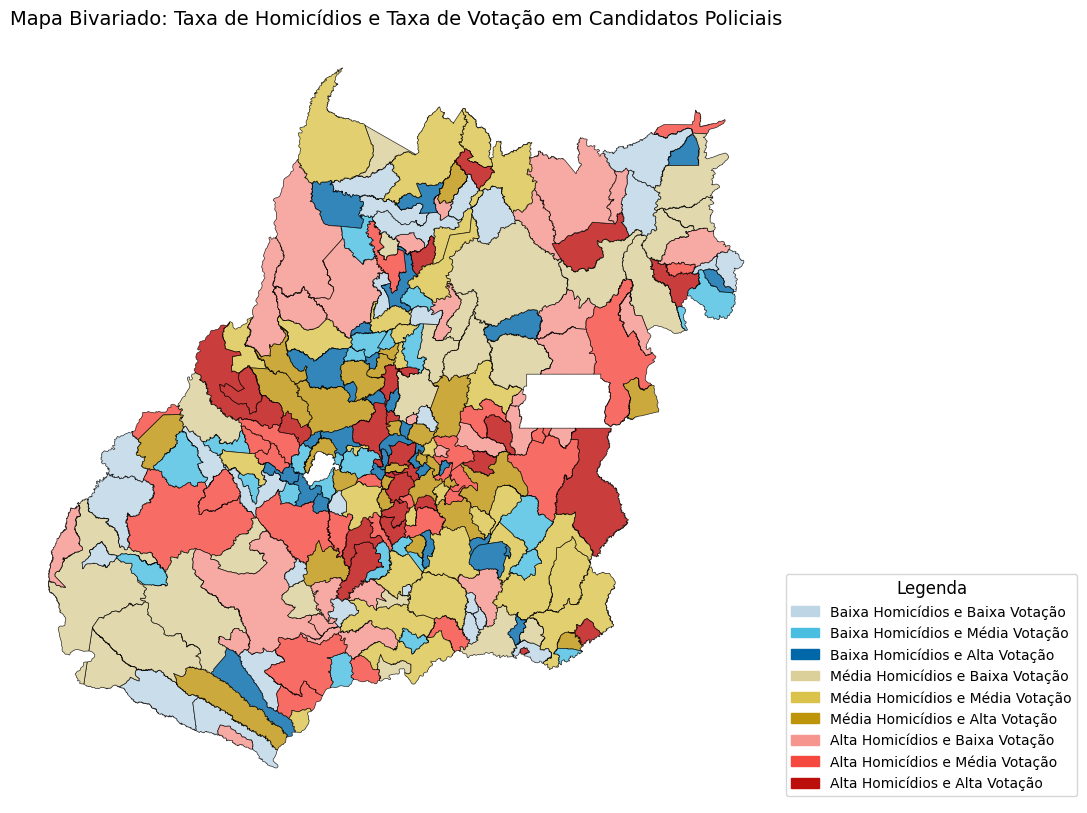

In [ ]:
# Calcular a taxa de homicídios por 100 mil habitantes
df_policia['tx_homicidios'] = (df_policia['Homicidios Dolosos'] / df_policia['habitantes']) * 100000

# Normalizar as variáveis para criar as classes bivariadas
df_policia['homicidios_class'] = pd.qcut(df_policia['tx_homicidios'], q=3, labels=[1, 2, 3])
df_policia['vot_class'] = pd.qcut(df_policia['tx_Vot'], q=3, labels=[1, 2, 3])

# Criar uma coluna com as combinações de classes bivariadas
df_policia['bivar_class'] = (
    df_policia['homicidios_class'].astype(str) + df_policia['vot_class'].astype(str)
)

# Unir os dados com o GeoDataFrame
gdf_policia = gdf.merge(df_policia, on='NM_MUNICIPIO')

colors = [
    "#BDD5E5",  # 11: Baixa Taxa de Homicídios e Baixa Votação
    "#49BEE1",  # 12: Baixa Taxa de Homicídios e Média Votação
    "#0068A8",  # 13: Baixa Taxa de Homicídios e Alta Votação
    "#DBCF9A",  # 21: Média Taxa de Homicídios e Baixa Votação
    "#DBC34B",  # 22: Média Taxa de Homicídios e Média Votação
    "#BE940B",  # 23: Média Taxa de Homicídios e Alta Votação
    "#F5958E",  # 31: Alta Taxa de Homicídios e Baixa Votação
    "#F5483E",  # 32: Alta Taxa de Homicídios e Média Votação
    "#BC0E0B",  # 33: Alta Taxa de Homicídios e Alta Votação
]

cmap = ListedColormap(colors)

# Plotar o mapa bivariado
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_policia.plot(
    ax=ax,
    column='bivar_class',
    cmap=cmap,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.8
)

# Configurar título e eixos
plt.title("Mapa Bivariado: Taxa de Homicídios e Taxa de Votação em Candidatos Policiais", fontsize=14)
ax.axis("off")

legenda_labels = {
    '11': 'Baixa Homicídios e Baixa Votação',
    '12': 'Baixa Homicídios e Média Votação',
    '13': 'Baixa Homicídios e Alta Votação',
    '21': 'Média Homicídios e Baixa Votação',
    '22': 'Média Homicídios e Média Votação',
    '23': 'Média Homicídios e Alta Votação',
    '31': 'Alta Homicídios e Baixa Votação',
    '32': 'Alta Homicídios e Média Votação',
    '33': 'Alta Homicídios e Alta Votação'
}

patches = [
    mpatches.Patch(color=colors[i], label=label)
    for i, label in enumerate(legenda_labels.values())
]

plt.legend(
    handles=patches,
    loc='lower left',
    title="Legenda",
    fontsize=10,
    title_fontsize=12,
    bbox_to_anchor=(1, 0)
)

plt.show()